<a href="https://colab.research.google.com/github/rogerzmukiibi/Zindi_PM2.5P-prediction/blob/main/PM25_Prediction_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt


from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [ ]:
# Function for features engineering
def create_df(data_path):

  # Reading file 
  df = pd.read_csv(data_path)

  # Identifying columns with 50% null values
  result = df.loc[:, df.isnull().mean() > 0.5]
  mask_null = result.columns
  df.drop(columns =  mask_null, inplace=True)

  # Dropping columns with redandunt setellite data data
  def get_cols_with_word(df, word):
    return [col for col in df.columns if word in col]
  
  albedo_cols = get_cols_with_word(df, "albedo")
  angle_cols = get_cols_with_word(df, "angle")
  cloud_cols = get_cols_with_word(df, "cloud")
  sat_columns = angle_cols + cloud_cols + albedo_cols
  df.drop(columns = sat_columns, inplace=True)

  # # Remove Outliers
  # if "target" in df.columns:
  #   df = df[df["target"] < 500]

  # Getting columns
  object_cols = ["Place_ID", "Date", "Place_ID X Date"]
  target_cols = get_cols_with_word(df, "target")
  features = df.columns.drop(object_cols + target_cols)

  # Imputing nal values
  imputer = KNNImputer(n_neighbors=5, weights='distance')
  df_imputed = imputer.fit_transform(df[features])
  df.loc[:, features] =df_imputed

  # # Perform linear interpolation on the data frame
  # df.loc[:, features] = df[features].interpolate(method='linear')


  return df

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ML/Zindi_project_Env/'
# Load raw files
train_df = pd.read_csv(f"{DATA_PATH}Train.csv")
test_df = pd.read_csv(f"{DATA_PATH}Test.csv")
samplesubmission = pd.read_csv(f"{DATA_PATH}SampleSubmission.csv")

# Load modified files
# train = create_df(f"{DATA_PATH}Train.csv")
# test = create_df(f"{DATA_PATH}Test.csv")


print(train.shape, test.shape)

(30557, 35) (16136, 30)


In [ ]:
Train["Place_ID"].nunique() + Test["Place_ID"].nunique()

340

In [ ]:
features = ['precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_sensor_altitude',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_CO_CO_column_number_density', 'L3_CO_H2O_column_number_density',
       'L3_CO_sensor_altitude', 'L3_HCHO_HCHO_slant_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf', 
       'L3_AER_AI_absorbing_aerosol_index',
       'L3_AER_AI_sensor_altitude', 'L3_SO2_SO2_column_number_density',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_SO2_SO2_slant_column_number_density',
       'L3_SO2_absorbing_aerosol_index']

In [ ]:
print((train[features] < 0).sum())

precipitable_water_entire_atmosphere                       0
relative_humidity_2m_above_ground                          0
specific_humidity_2m_above_ground                          0
temperature_2m_above_ground                             4106
u_component_of_wind_10m_above_ground                   13888
v_component_of_wind_10m_above_ground                   15201
L3_NO2_NO2_column_number_density                          27
L3_NO2_NO2_slant_column_number_density                     0
L3_NO2_absorbing_aerosol_index                         27534
L3_NO2_sensor_altitude                                     0
L3_NO2_stratospheric_NO2_column_number_density             0
L3_NO2_tropopause_pressure                                 0
L3_NO2_tropospheric_NO2_column_number_density            157
L3_O3_O3_column_number_density                             0
L3_O3_O3_effective_temperature                             0
L3_CO_CO_column_number_density                             0
L3_CO_H2O_column_number_

The negative values are in fields which can justifiably have negative values 

<a name="Statistics"></a>
## 3. Statistical summaries

In [ ]:
# Choosing scaler
yeojohnson = True
standard_scaler = False

In [ ]:
if yeojohnson:
  # apply yeojohnson transform
  X_Scaler = PowerTransformer(method='yeo-johnson')
  y_Scaler = PowerTransformer(method='yeo-johnson')
elif standard_scaler:
  X_Scaler = StandardScaler()
  y_Scaler = StandardScaler()
  

train.loc[:, features] = X_Scaler.fit_transform(train[features])
train.loc[:, ['target']] = y_Scaler.fit_transform(train[['target']])

In [ ]:
# Train statistical summary
train[["target"]].describe()

,target
count,3.055700e+04
mean,-1.590507e-16
std,1.000016e+00
min,-3.561124e+00
25%,-8.227990e-01
50%,4.620347e-02
75%,6.845684e-01
max,4.455177e+00


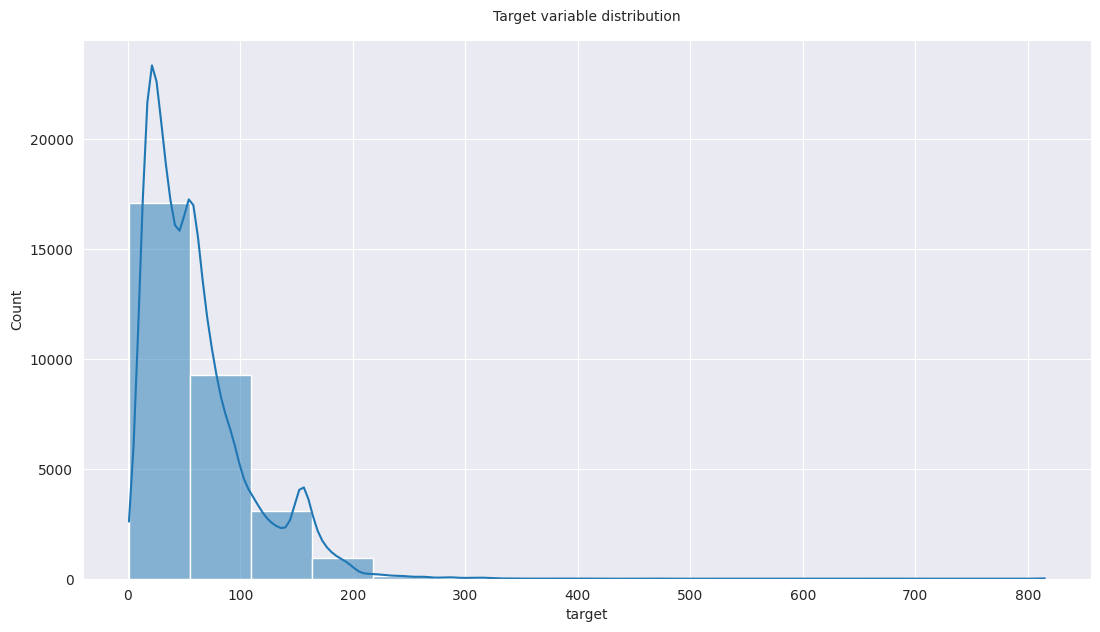

None

2.043157339845919

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train_df.target, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 10)
display(plt.show(), train_df.target.skew())

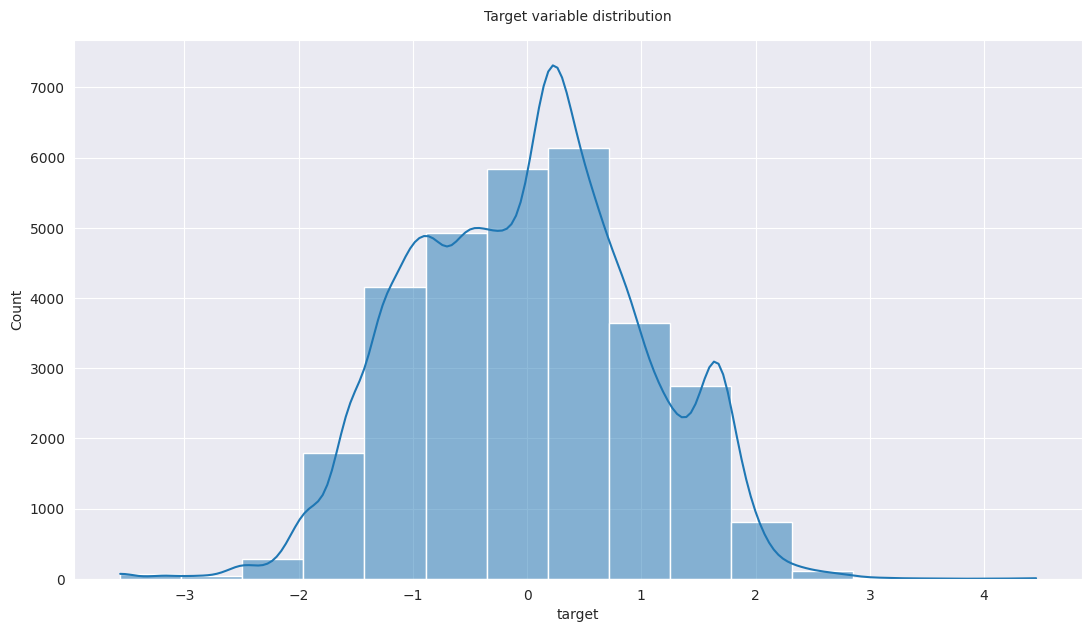

None

-0.008725973508909189

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.target, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 10)
display(plt.show(), train.target.skew())

The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform

Used the Yeo-Johnson transformation since it is a power transformation similar to Box-Cox, but it works for both positive and negative values, unlike Box-Cox which requires strictly positive values. 

<a name="Missing"></a>
## 4. Missing values and duplicates

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(False, False)

In [ ]:
# Perform linear interpolation on the data frame
#df.interpolate(method='linear', inplace=True)

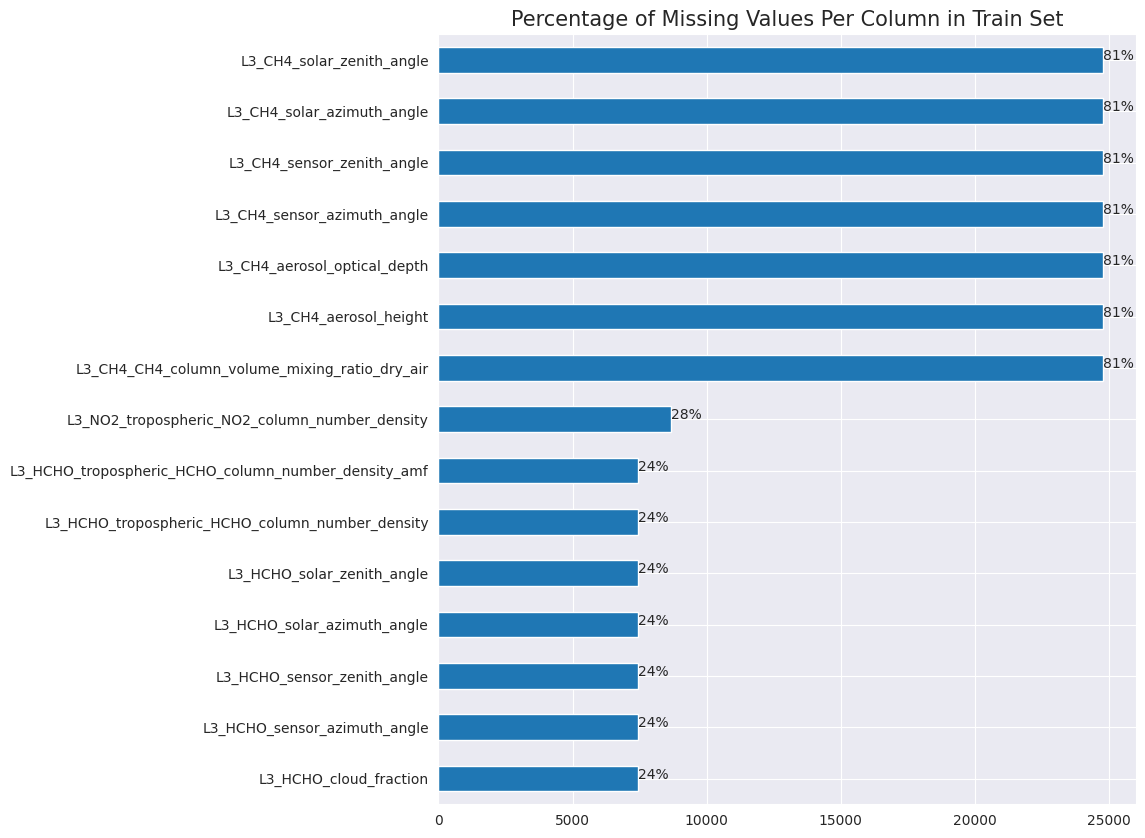

In [ ]:
# Plot missing values in train set
ax = train_df.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train_df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Drop columns with high missing values (50% missing)
 - Impute the other missing values using the knn imputer

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Outliers"></a>
## 5. Outliers


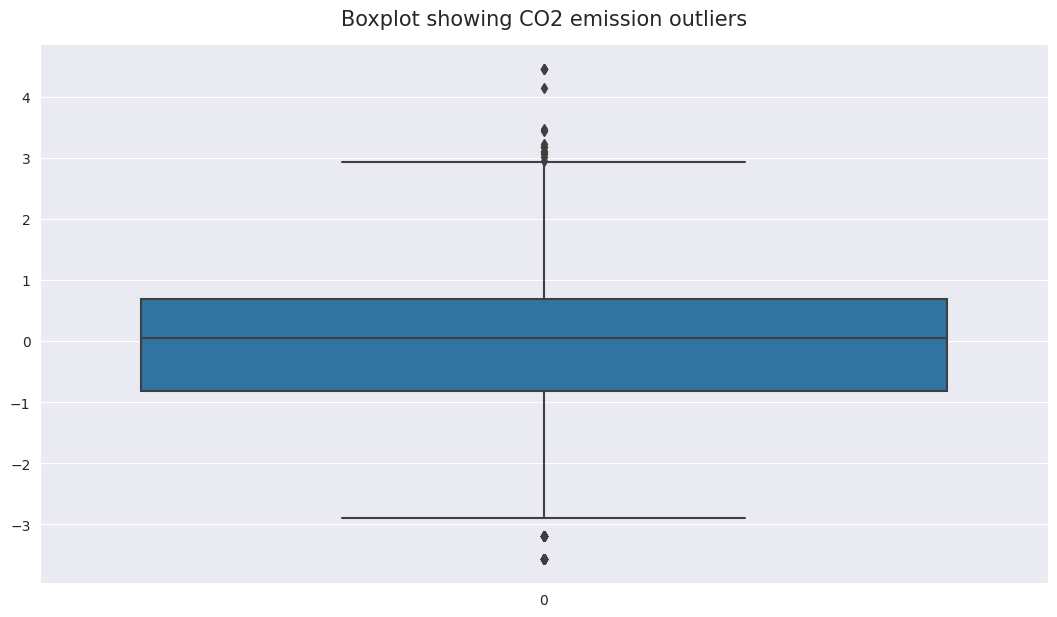

In [ ]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.target)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

Creating a pipeline for data transformation

<a name="Engineering"></a>
## 10. Feature engineering









 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

<a name="Modelling"></a>
## 11.  Modelling

* **Splitting the data**
- Split basing on cities (20% -> 65 cites in the test data)


## Random Forest

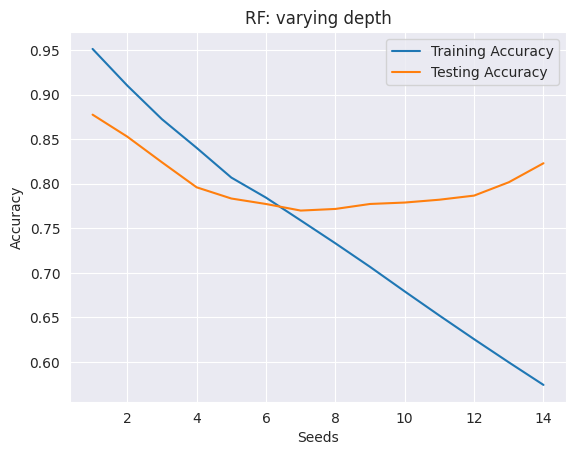

In [ ]:
# select unique items
cities = train['Place_ID'].unique()

# create a new DataFrame with the selected unique items
Test = train[train['Place_ID'].isin(cities[:65])]
Train = train[~train['Place_ID'].isin(cities[:65])]

target = 'target'
# Spliting data
X_Train = Train[features]
y_Train = Train[target]

X_Test = Test[features]
y_Test = Test[target]

# Create neighbors
depth = np.arange(1, 15)
train_accuracies = {}
test_accuracies = {}

for max_depth in depth:
  # Set up model
  clf = RandomForestRegressor(random_state = SEED, n_jobs=-1, n_estimators=2, 
                           max_depth=max_depth)
  
  clf.fit(X_Train, y_Train)

  # Making predictions
  y_pred_train = clf.predict(X_Train)
  y_pred_test = clf.predict(X_Test)

  # Compute accuracy
  train_accuracies[max_depth] = mean_squared_error(y_Train, y_pred_train, squared=False)
  test_accuracies[max_depth] = mean_squared_error(y_Test, y_pred_test, squared=False)

plt.title("RF: varying depth")

# Plot training accuracies
plt.plot(depth, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot( depth, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Seeds")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

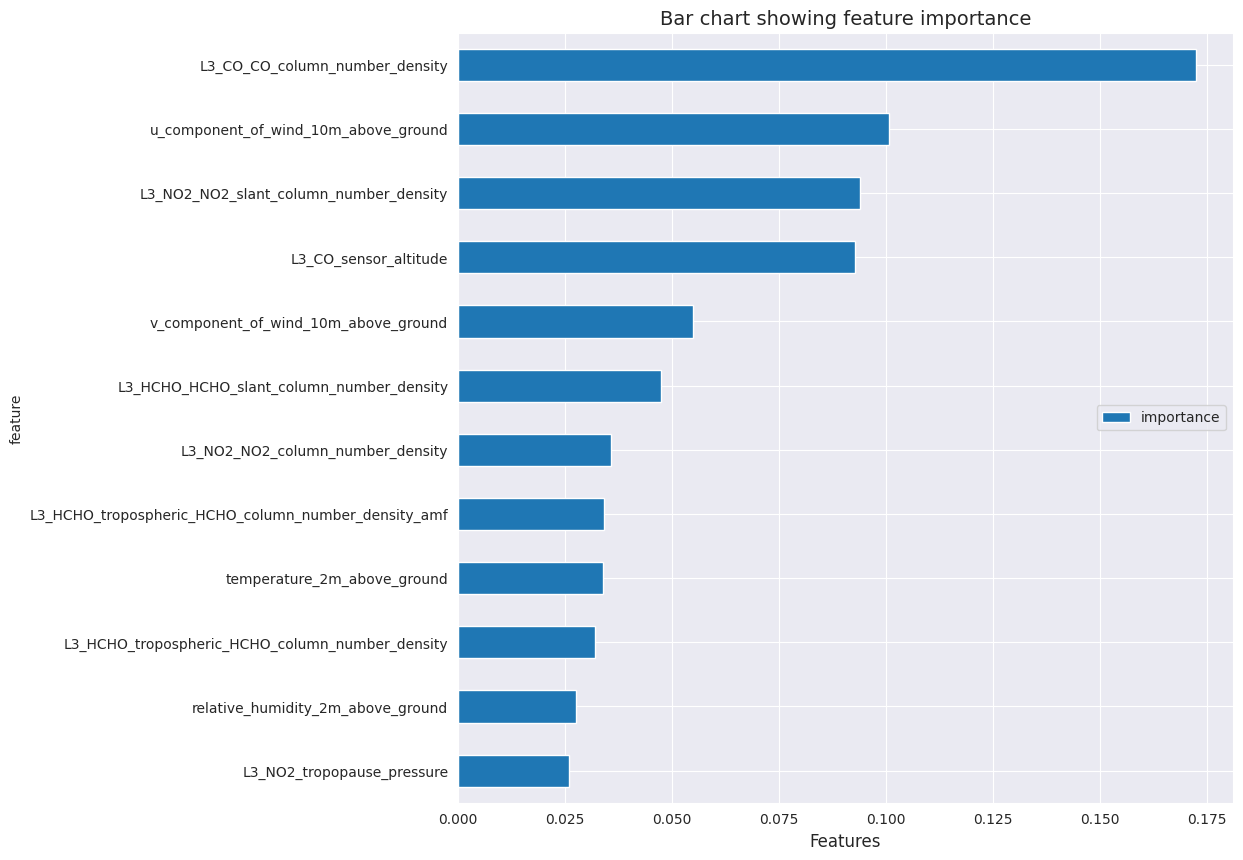

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': train[features].columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [ ]:
# Model Selection
RF = True
DT = False
RG = False
POLY  = False
deg = 2

In [ ]:
# Spliting data for training
X_train = train[features]
y_train = train[target]

In [ ]:
# Instantiating the model

if RF:
  model = RandomForestRegressor(random_state = SEED, n_estimators=2, 
                           max_depth=max_depth)
elif DT:
  model = DecisionTreeRegressor(max_depth=2, random_state=SEED)
elif RG:
  model = Ridge()
elif POLY:
    # Transform the train features to a higher degree polynomial
  poly_features = PolynomialFeatures(degree=deg)
  X_train = poly_features.fit_transform(X_train)
  model = LinearRegression()

model.fit(X_train, y_train)
# Making predictions
y_pred_train = model.predict(X_train)

# Measuring the accuracy of the model
print(f'Train RMSE Score: {mean_squared_error(y_train, y_pred_train, squared=False).round(3)}') # 31.612502792990366

Train RMSE Score: 0.557


<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [ ]:
baseline = pd.read_csv(f'{DATA_PATH}BaselineSubmission.csv')
y_pred_baseline =  baseline["target"]

baseline.head()

,Place_ID,target
0,0OS9LVX X 2020-01-02,43.45
1,0OS9LVX X 2020-01-03,38.32
2,0OS9LVX X 2020-01-04,40.42
3,0OS9LVX X 2020-01-05,35.01
4,0OS9LVX X 2020-01-06,34.25


In [ ]:
test.drop([ 'Place_ID X Date', 'Date', 'Place_ID'], axis = 1).shape

(16136, 27)

In [ ]:
# Make prediction on the test set
test_df = test.drop([ 'Place_ID X Date', 'Date', 'Place_ID'], axis = 1)

# Transform the data
test_df.loc[:, features] = X_Scaler.transform(test[features])

if POLY:
    # Transform the test features to a higher degree polynomial
  poly_features = PolynomialFeatures(degree=deg)
  test_df = poly_features.fit_transform(test_df)

predictions = model.predict(test_df)


In [ ]:

# # Create a submission file
sub_file = pd.DataFrame({"Place_ID": samplesubmission['Place_ID X Date'], 'target': predictions})
sub_file.loc[:, ['target']] = y_Scaler.inverse_transform(sub_file[['target']])
print(f'Test RMSE Score: {mean_squared_error(y_pred_baseline, predictions, squared=False).round(3)}')

Test RMSE Score: 66.594


Model Perfomance before 
* RF = Baseline
* DT = 23.782
* Ridge = 22.403
* Poly_2 = 19.53

In [ ]:
sub_file.head()

,Place_ID,target
0,0OS9LVX X 2020-01-02,15.462607
1,0OS9LVX X 2020-01-03,15.008927
2,0OS9LVX X 2020-01-04,20.116587
3,0OS9LVX X 2020-01-05,34.615252
4,0OS9LVX X 2020-01-06,34.615252


In [ ]:
# Create file
sub_file.to_csv(f'{DATA_PATH}ASub.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;